# SGP-Based IPP

In [1]:
import os
os.environ["TF_ENABLE_ONEDNN_OPTS"] = "0"

import numpy as np
import tensorflow as tf

from sgptools.utils.metrics import *
from sgptools.utils.data import *
from sgptools.utils.misc import *
from sgptools.utils.tsp import run_tsp
from sgptools.utils.gpflow import get_model_params
from sgptools.models.continuous_sgp import *
from sgptools.models.core.transformations import *

import matplotlib.pyplot as plt

np.random.seed(0)
tf.random.set_seed(0)

2024-05-05 12:00:01.230242: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 12:00:01.262867: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-05-05 12:00:01.263699: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-05 12:00:01.834420: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Get the data and initial SGP parameters

2024-05-05 12:00:06.713431: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


╒═════════════════════════╤═══════════╤══════════════════╤═════════╤═════════════╤═════════╤═════════╤═══════════════════╕
│ name                    │ class     │ transform        │ prior   │ trainable   │ shape   │ dtype   │ value             │
╞═════════════════════════╪═══════════╪══════════════════╪═════════╪═════════════╪═════════╪═════════╪═══════════════════╡
│ GPR.kernel.variance     │ Parameter │ Softplus         │         │ True        │ ()      │ float64 │ 0.661             │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.kernel.lengthscales │ Parameter │ Softplus         │         │ True        │ (2,)    │ float64 │ [0.34138 0.35271] │
├─────────────────────────┼───────────┼──────────────────┼─────────┼─────────────┼─────────┼─────────┼───────────────────┤
│ GPR.likelihood.variance │ Parameter │ Softplus + Shift │         │ True        │ ()      │ float64 │ 0.03165           │
╘═══════════════

Text(0.5, 1.0, 'Data Field')

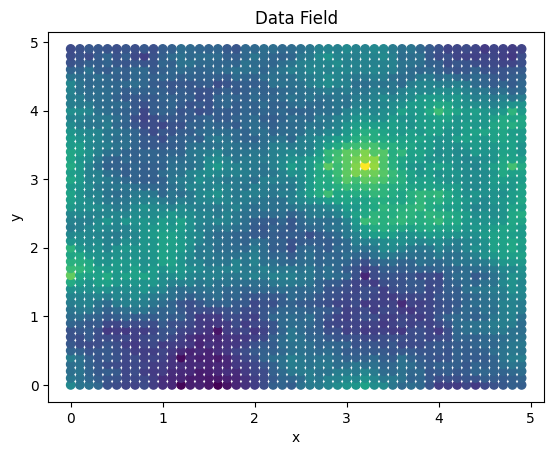

In [2]:
# Get the synthetic elevation data
dataset = 'synthetic'
X_train, y_train, X_test, y_test, candidates, X, y = get_dataset(dataset)

# Train the GP and get the model parameters
_, noise_variance, kernel = get_model_params(X_train, y_train, 
                                             lengthscales=[1.0, 1.0], 
                                             optimizer='scipy')

plt.scatter(X[:, 0], X[:, 1], c=y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data Field')


# Offline Single-Robot IPP with Point Sensing

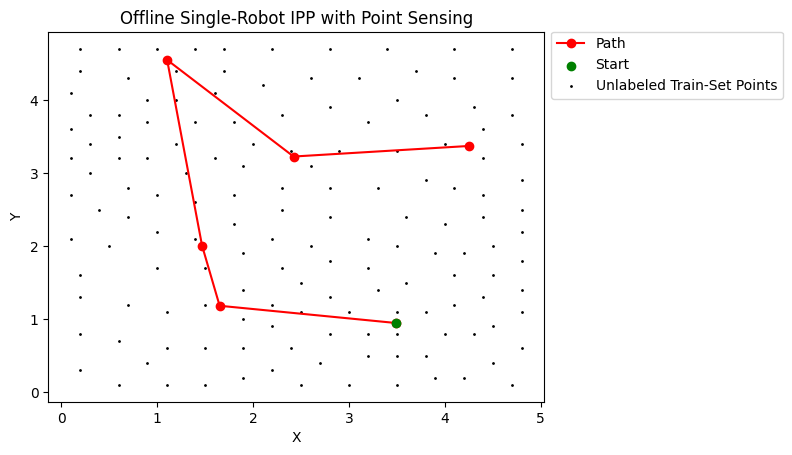

In [3]:
num_robots = 1
num_placements = 6

# Initialize inducing points and get initial path
Xu_init = get_inducing_pts(X_train, 
                           num_placements*num_robots)
Xu_init, _ = run_tsp(Xu_init, 
                     num_vehicles=num_robots)
Xu_init = Xu_init[0]

# Setup unconstrained IPP transform and optimize it
transform = IPPTransform(num_robots=num_robots, num_dim=2)
sgpr, _ = continuous_sgp(num_placements, 
                         X_train, 
                         noise_variance, 
                         kernel,
                         transform,
                         Xu_init=Xu_init, 
                         max_steps=1000)

# Get solution inducing points
sgp_sol_sp = sgpr.inducing_variable.Z.numpy()
sgp_paths = sgp_sol_sp.reshape(num_robots, num_placements, 2)

# Plot the solution
plot_paths(sgp_paths, candidates, title="Offline Single-Robot IPP with Point Sensing")

# Offline Single-Robot IPP with Continuous Sensing

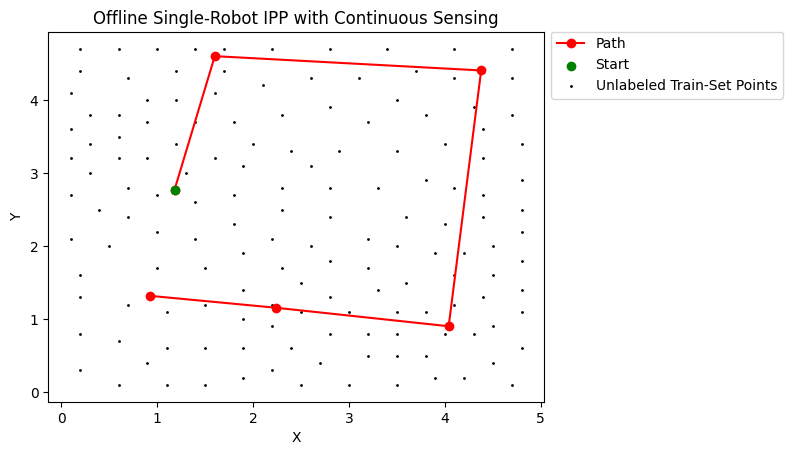

In [4]:
num_robots = 1
num_placements = 6

# Initialize inducing points and get initial path
Xu_init = get_inducing_pts(X_train, num_placements*num_robots)
Xu_init, _ = run_tsp(Xu_init, 
                     num_vehicles=num_robots)
Xu_init = Xu_init[0]

# Setup unconstrained IPP transform with sampling rate=50
# and optimize it
transform = IPPTransform(num_robots=num_robots,
                           num_dim=2,
                           sampling_rate=50)
sgpr, _ = continuous_sgp(num_placements, 
                         X_train, 
                         noise_variance, 
                         kernel,
                         transform,
                         Xu_init=Xu_init, 
                         max_steps=1000)

# Get solution inducing points
sgp_sol_sp = sgpr.inducing_variable.Z.numpy()
sgp_paths = sgp_sol_sp.reshape(num_robots, num_placements, 2)

# Plot the solution
plot_paths(sgp_paths, candidates, title="Offline Single-Robot IPP with Continuous Sensing")

# Offline Single-Robot IPP with Continuous Non-point FoV Sensor

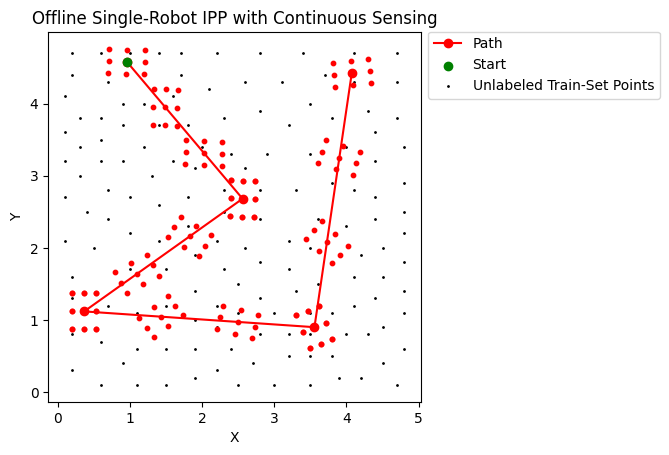

In [5]:
num_robots = 1
num_placements = 5

# Initialize inducing points and get initial path
Xu_init = get_inducing_pts(X_train, num_placements*num_robots)
Xu_init, _ = run_tsp(Xu_init, 
                     num_vehicles=num_robots)
Xu_init = Xu_init[0]

# Add random angles to inducing points to initialize the rotation angle of the FoVs
angles = np.random.uniform(-np.pi, np.pi, num_placements).reshape(-1, 1)
Xu_init = np.concatenate([Xu_init, angles], axis=1)

# Setup unconstrained IPP transform with square FoV transform 
# with length 1.5 and 3x3 point approximation, 
# and continuous sensing model (sampling rate of 4), and optimize it
square_transform = SquareTransform(length=0.5, num_side=3)
transform = IPPTransform(num_robots=num_robots,
                           num_dim=3,
                           sampling_rate=4,
                           sensor_model=square_transform)
sgpr, _ = continuous_sgp(num_placements, 
                         X_train, 
                         noise_variance, 
                         kernel,
                         transform,
                         Xu_init=Xu_init, 
                         max_steps=1000)

# Get solution inducing points
sgp_sol_sp = sgpr.inducing_variable.Z.numpy()[:, :2]
sgp_paths = sgp_sol_sp.reshape(num_robots, -1 , 2)

# Plot the solution path and the FoVs
plot_paths(sgp_paths, candidates, title="Offline Single-Robot IPP with Continuous Sensing")
sgp_sol_sp = sgpr.inducing_variable.Z
sgp_sol_sp = sgpr.transform.expand(sgp_sol_sp).numpy()
plt.scatter(sgp_sol_sp[:, 0], sgp_sol_sp[:, 1], s=10, c='r')
plt.gca().set_aspect('equal')

# Offline Multi-Robot IPP with Continuous Sensing and a Distance Budget

Distances: [4.99658757 4.97094856 4.96395641]


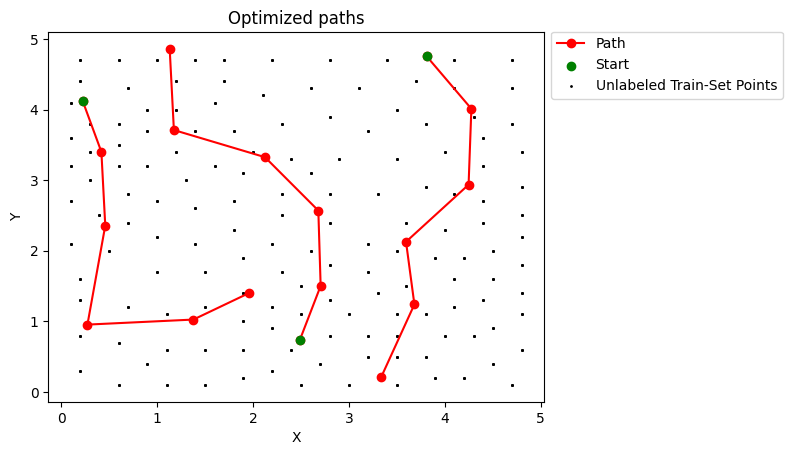

In [6]:
num_robots = 3
num_placements = 6

# Initialize inducing points and get initial path 
# resample to ensure same number of waypoints in each path
Xu_init = get_inducing_pts(X_train, num_placements*num_robots)
Xu_init, _ = run_tsp(Xu_init, 
                     num_vehicles=num_robots,
                     max_dist=30,
                     resample=num_placements)
Xu_init = Xu_init.reshape(-1, 2)

# Setup distance constrained 3 robot IPP transform
# with continuous sensing model (sampling rate of 20) and 
# a distance budget of 5. and optimize it
transform = IPPTransform(num_robots=num_robots,
                           num_dim=2,
                           sampling_rate=20,
                           distance_budget=5.,
                           constraint_weight=500.)
sgpr, _ = continuous_sgp(num_placements, 
                         X_train, 
                         noise_variance, 
                         kernel,
                         transform,
                         Xu_init=Xu_init, 
                         max_steps=5000)

# Get solution inducing points
sol_sp = sgpr.inducing_variable.Z.numpy()
sol_paths = sol_sp.reshape(num_robots, 
                           num_placements, 2)

# Plot the solution path
plot_paths(sol_paths, candidates, title="Optimized paths")
print("Distances:", transform.distance(sol_sp).numpy())